In [2]:
# 1 — Setup (imports, device, paths, features, helpers)

import time, math, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

plt.rcParams["figure.dpi"] = 160

# ---- Paths (edit here if your layout differs)
DATA_ROOT   = Path("../data")
PROC_DIR    = DATA_ROOT / "processed"
STATS_DIR   = DATA_ROOT / "stats"
MODEL_DIR   = DATA_ROOT / "models"
FORE_DIR    = DATA_ROOT / "forecasts"         # subfolders created per K
RESULTS_DIR = DATA_ROOT / "results"
FIG_DIR     = RESULTS_DIR / "figures"
TAB_DIR     = RESULTS_DIR / "tables"
for d in [FORE_DIR, RESULTS_DIR, FIG_DIR, TAB_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ---- Feature order MUST match your training data
FEATURES = ["bh_mass","bh_acc","stellar_mass","sfr","halo_mass","vel_disp"]
F = len(FEATURES)

# ---- Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[1] Using device: {device}")

# ---- Load processed arrays + stats
ids_path   = PROC_DIR / "ids.npy"
snaps_path = PROC_DIR / "snapshots.npy"
feats_path = PROC_DIR / "features.npy"
mean_path  = STATS_DIR / "feat_mean.npy"
std_path   = STATS_DIR / "feat_std.npy"

ids   = np.load(ids_path)
snaps = np.load(snaps_path).astype(int)
Xraw  = np.load(feats_path).astype(np.float32)
mean  = np.load(mean_path).astype(np.float32)
std   = np.load(std_path).astype(np.float32)

assert Xraw.shape[1] == F, f"Expected {F} features but got {Xraw.shape[1]}"

def to_norm(x): return (x - mean) / (std + 1e-8)
def to_real(z): return z * std + mean

# ---- Simple metrics
def rmse(A, B, axis=0): return np.sqrt(np.mean((A - B) ** 2, axis=axis))
def mae(A, B, axis=0):  return np.mean(np.abs(A - B), axis=axis)

print(f"[1] Loaded: ids={ids.shape}, snaps={snaps.shape}, features={Xraw.shape}, stats={mean.shape}/{std.shape}")


[1] Using device: cpu
[1] Loaded: ids=(37500,), snaps=(37500,), features=(37500, 6), stats=(6,)/(6,)


In [3]:
# 2 — Model rebuild + checkpoint load (+WINDOW)

class BHSequenceLSTM(nn.Module):
    def __init__(self, input_size, hidden=128, layers=2, dropout=0.1, output_size=None):
        super().__init__()
        if output_size is None: output_size = input_size
        self.lstm = nn.LSTM(
            input_size, hidden, num_layers=layers, batch_first=True,
            dropout=dropout if layers > 1 else 0.0
        )
        self.head = nn.Sequential(
            nn.Linear(hidden, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, output_size)
        )
    def forward(self, x):            # x: [B, W, F]
        h, _ = self.lstm(x)          # [B, W, H]
        return self.head(h[:, -1, :])# [B, F]

# Load checkpoint
CKPT_PATH = MODEL_DIR / "blackhole_evolution_lstm.pt"
ckpt = torch.load(CKPT_PATH, map_location="cpu")
WINDOW = int(ckpt.get("window", 8))
print(f"[2] Loaded checkpoint: {CKPT_PATH.name} | WINDOW={WINDOW}")

# Build model as trained
model = BHSequenceLSTM(input_size=F, hidden=128, layers=2, dropout=0.1, output_size=F).to(device)
model.load_state_dict(ckpt["state_dict"])
model.eval()
print("[2] Model ready.")


[2] Loaded checkpoint: blackhole_evolution_lstm.pt | WINDOW=8
[2] Model ready.


[3] step 1/10 | elapsed 0.3s | ETA 2.5s
[3] step 2/10 | elapsed 0.3s | ETA 1.3s
[3] step 3/10 | elapsed 0.4s | ETA 0.9s
[3] step 4/10 | elapsed 0.4s | ETA 0.6s
[3] step 5/10 | elapsed 0.5s | ETA 0.5s
[3] step 6/10 | elapsed 0.5s | ETA 0.3s
[3] step 7/10 | elapsed 0.6s | ETA 0.2s
[3] step 8/10 | elapsed 0.6s | ETA 0.2s
[3] step 9/10 | elapsed 0.7s | ETA 0.1s
[3] step 10/10 | elapsed 0.7s | ETA 0.0s
[3] Finished K=10 for N=2500 subhalos in 0.7s (~0.07s/step)
[3] Wrote 2500 per-subhalo CSVs → ../data/forecasts/extrapolated_K10
[3] Aggregate: ../data/results/tables/forecast_mean_trajectory_K10.csv
[3] Figure:    ../data/results/figures/forecast_mean_trajectory_K10.png


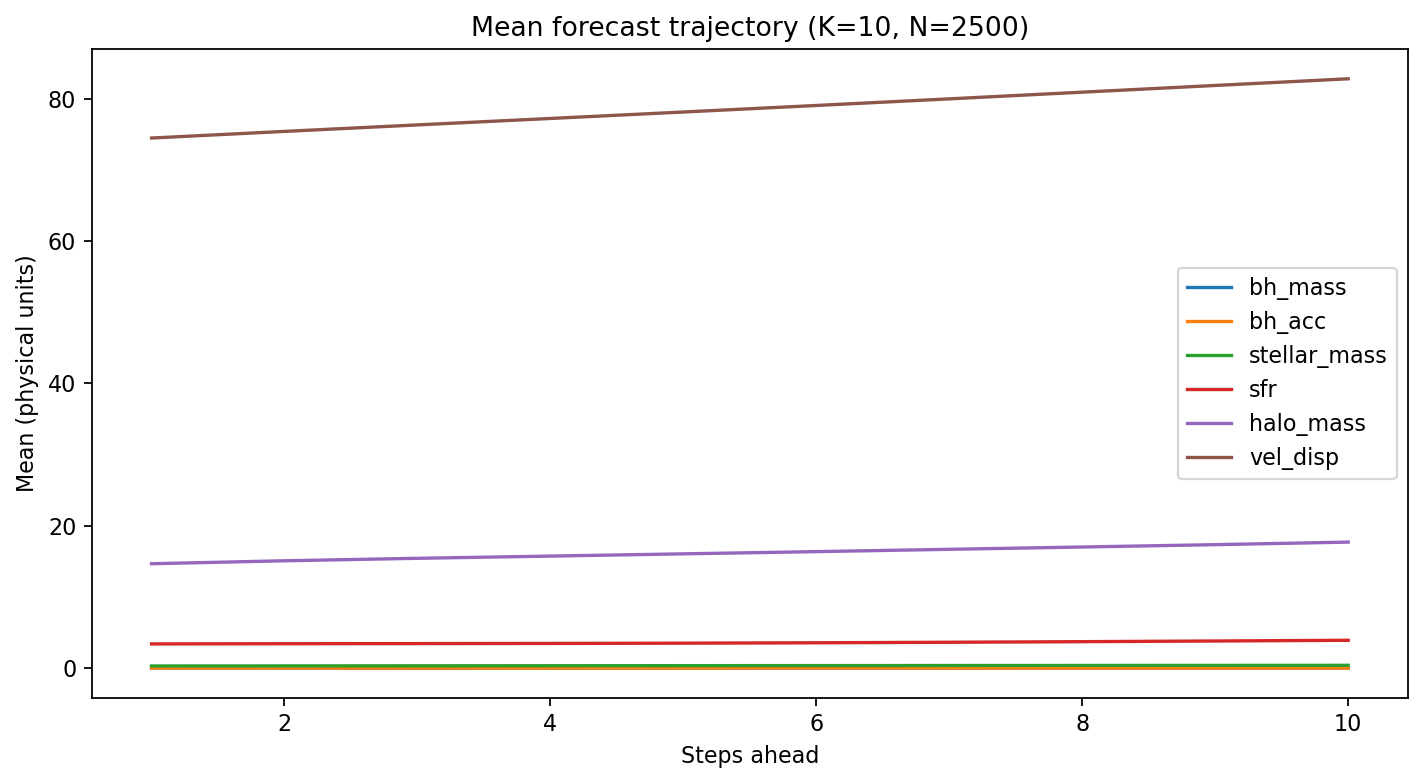

In [5]:
# 3 — Multi-step forecasts (K-step, batched, progress ETA)
# Builds last-window per subhalo, rolls forward K steps, saves per-subhalo CSVs + aggregate mean trajectory and figure.

K = 10              # change as you like (e.g., 20)
SUBSET_N = None     # e.g., 500 to test quickly; None = all eligible
PROGRESS_EVERY = 1  # print every k steps

csv_long_path = PROC_DIR / "black_hole_evolution_tng100.csv"
df_long = pd.read_csv(csv_long_path)

# Collect last windows
win_list, sid_list, last_snap_list = [], [], []
for sid in np.unique(ids):
    sub = df_long[df_long["subhalo_id"] == sid].sort_values("snapshot")
    if len(sub) < WINDOW: 
        continue
    Xw_real = sub[FEATURES].iloc[-WINDOW:].to_numpy(dtype=np.float32)
    win_list.append(Xw_real)
    sid_list.append(int(sid))
    last_snap_list.append(int(sub["snapshot"].iloc[-1]))

if SUBSET_N is not None:
    win_list       = win_list[:SUBSET_N]
    sid_list       = sid_list[:SUBSET_N]
    last_snap_list = last_snap_list[:SUBSET_N]

N = len(win_list)
if N == 0:
    raise RuntimeError("No subhalos have ≥ WINDOW snapshots. Aborting.")

FORE_K_DIR = FORE_DIR / f"extrapolated_K{K}"
FORE_K_DIR.mkdir(parents=True, exist_ok=True)

# Prepare batch window (normalized)
Xw = (np.stack(win_list, axis=0) - mean) / (std + 1e-8)
Xw = np.nan_to_num(Xw, nan=0.0, posinf=0.0, neginf=0.0)
Xw_t = torch.from_numpy(Xw).float().to(device)  # [N,W,F]

# Storage for predictions (REAL units)
preds = np.empty((N, K, F), dtype=np.float32)

t0 = time.perf_counter()
for k in range(1, K + 1):
    with torch.no_grad():
        y_norm = model(Xw_t)  # [N,F], normalized
    y_real = (y_norm.cpu().numpy() * std + mean).astype(np.float32)
    y_real = np.maximum(y_real, 0.0)            # non-negative clamp
    preds[:, k-1, :] = y_real

    # slide window forward in normalized space
    y_norm_np = y_norm.cpu().numpy()[:, None, :]  # [N,1,F]
    Xw_np = Xw_t.cpu().numpy()
    Xw_np = np.concatenate([Xw_np[:, 1:, :], y_norm_np], axis=1)
    Xw_t = torch.from_numpy(Xw_np).float().to(device)

    if k % PROGRESS_EVERY == 0:
        elapsed = time.perf_counter() - t0
        eta = elapsed / k * (K - k)
        print(f"[3] step {k}/{K} | elapsed {elapsed:.1f}s | ETA {eta:.1f}s")

total = time.perf_counter() - t0
print(f"[3] Finished K={K} for N={N} subhalos in {total:.1f}s (~{total/max(K,1):.2f}s/step)")

# Save per-subhalo forecasts
paths = []
for i, sid in enumerate(sid_list):
    snaps_future = [last_snap_list[i] + h for h in range(1, K+1)]
    out_df = pd.DataFrame(preds[i], columns=FEATURES)
    out_df.insert(0, "snapshot", snaps_future)
    out_df.insert(0, "subhalo_id", sid)
    p = FORE_K_DIR / f"forecast_subhalo_{sid}_K{K}.csv"
    out_df.to_csv(p, index=False)
    paths.append(p)

# Aggregate mean trajectory
agg = []
for i in range(N):
    tmp = pd.DataFrame(preds[i], columns=FEATURES)
    tmp["step_ahead"] = np.arange(1, K+1)
    agg.append(tmp)
mean_traj = pd.concat(agg).groupby("step_ahead")[FEATURES].mean().reset_index()
mean_traj.to_csv(TAB_DIR / f"forecast_mean_trajectory_K{K}.csv", index=False)

plt.figure(figsize=(9,5))
for f in FEATURES:
    plt.plot(mean_traj["step_ahead"], mean_traj[f], label=f)
plt.xlabel("Steps ahead"); plt.ylabel("Mean (physical units)")
plt.title(f"Mean forecast trajectory (K={K}, N={N})")
plt.legend()
fig_mt = FIG_DIR / f"forecast_mean_trajectory_K{K}.png"
plt.tight_layout(); plt.savefig(fig_mt, dpi=200)

print(f"[3] Wrote {len(paths)} per-subhalo CSVs → {FORE_K_DIR}")
print(f"[3] Aggregate: {TAB_DIR / f'forecast_mean_trajectory_K{K}.csv'}")
print(f"[3] Figure:    {fig_mt}")


[4] horizon 1: N=17500 | RMSE(mean)=4.959e+00 | elapsed 1.8s
[4] horizon 2: N=15000 | RMSE(mean)=5.626e+00 | elapsed 2.6s
[4] horizon 3: N=12500 | RMSE(mean)=6.000e+00 | elapsed 3.4s
[4] horizon 4: N=10000 | RMSE(mean)=6.547e+00 | elapsed 4.5s
[4] horizon 5: N=7500 | RMSE(mean)=7.164e+00 | elapsed 5.4s
[4] horizon 6: N=5000 | RMSE(mean)=7.419e+00 | elapsed 6.8s
[4] horizon 7: N=2500 | RMSE(mean)=9.411e+00 | elapsed 7.1s
[4] horizon 8: 0 samples (skipping)
[4] horizon 9: 0 samples (skipping)
[4] horizon 10: 0 samples (skipping)
[4] Saved: ../data/results/tables/horizon_rmse.csv, ../data/results/tables/horizon_mae.csv, ../data/results/figures/horizon_rmse.png
[4] Sample counts per horizon: {1: 17500, 2: 15000, 3: 12500, 4: 10000, 5: 7500, 6: 5000, 7: 2500}


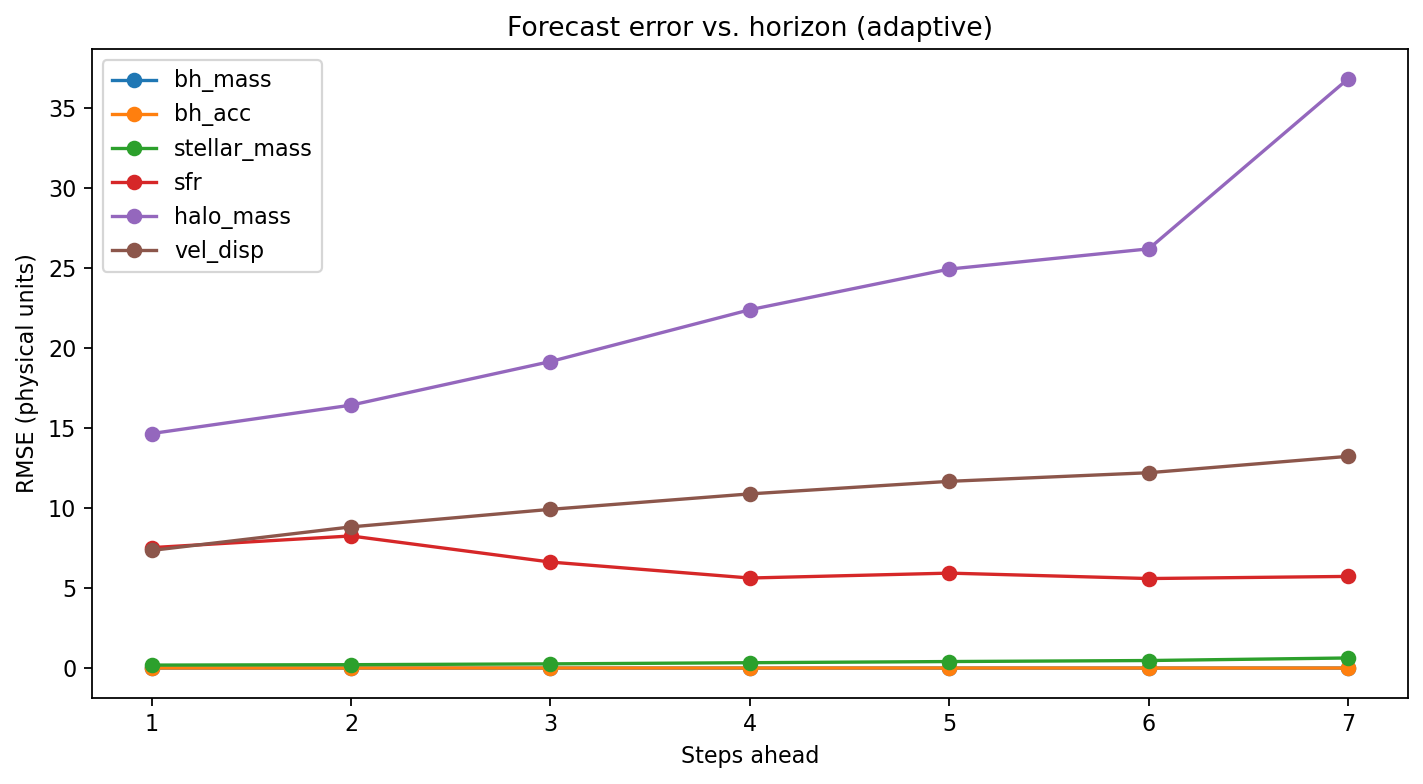

In [7]:
# 4 — Adaptive accuracy vs. horizon (works even when long futures are scarce)
# For each horizon h, only uses windows that truly have h future steps.
# It rolls the model h times from each window and compares to the true h-step-ahead target.

import time
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

K_eval = 10   # desired max horizon; will shrink automatically if needed
t0 = time.perf_counter()

# ---- Build normalized sequences per subhalo
seqs = {}
for sid in np.unique(ids):
    m = (ids == sid)
    s = snaps[m]
    x = Xraw[m]
    order = np.argsort(s)
    x = x[order]
    x = (x - mean) / (std + 1e-8)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    seqs[int(sid)] = x

# ---- Helper to collect windows that have >= h future steps, and their true h-step target
def collect_windows_for_h(seqs, h, window):
    XW_list, Y_list = [], []
    for sid, x in seqs.items():
        # need at least window + h samples to evaluate horizon h
        if len(x) < window + h:
            continue
        # windows ending at t-1 with future target at t+h-1 (0-index)
        # t ranges so that (t + h - 1) < len(x)  =>  t <= len(x) - h
        for t in range(window, len(x) - h + 1):
            XW_list.append(x[t-window:t, :])      # [W, F]
            Y_list.append(x[t + h - 1, :])        # [F]
    if not XW_list:
        return None, None
    return np.stack(XW_list).astype(np.float32), np.stack(Y_list).astype(np.float32)

# ---- Evaluate per-horizon with autoregressive rollouts
rmse_rows, mae_rows, counts = [], [], []

H_max_available = 0
for h in range(1, K_eval + 1):
    XW_h, Y_h = collect_windows_for_h(seqs, h, WINDOW)
    if XW_h is None:
        print(f"[4] horizon {h}: 0 samples (skipping)")
        continue

    H_max_available = h
    N_h = len(XW_h)
    counts.append((h, N_h))
    Xw_t = torch.from_numpy(XW_h).float().to(device)

    # roll h steps
    y_pred = None
    for step in range(h):
        with torch.no_grad():
            y_pred = model(Xw_t)                  # [N_h, F] (normalized)
        # slide window with the predicted step
        y_exp = y_pred[:, None, :].detach().cpu().numpy()
        Xw_np = Xw_t.cpu().numpy()
        Xw_np = np.concatenate([Xw_np[:, 1:, :], y_exp], axis=1)
        Xw_t = torch.from_numpy(Xw_np).float().to(device)

    # y_pred is the h-step prediction in normalized space; compare with Y_h
    P_r = y_pred.cpu().numpy() * std + mean
    T_r = Y_h * std + mean

    rmse_h = np.sqrt(np.mean((P_r - T_r) ** 2, axis=0))  # per feature
    mae_h  = np.mean(np.abs(P_r - T_r), axis=0)

    rmse_rows.append([h] + rmse_h.tolist())
    mae_rows.append([h]  + mae_h.tolist())

    elapsed = time.perf_counter() - t0
    print(f"[4] horizon {h}: N={N_h} | RMSE(mean)={rmse_h.mean():.3e} | elapsed {elapsed:.1f}s")

if H_max_available == 0:
    raise RuntimeError("No horizons available with current WINDOW. Try reducing WINDOW or ensure sequences are longer.")

# ---- Save tables
rmse_df = pd.DataFrame(rmse_rows, columns=["horizon"] + FEATURES)
mae_df  = pd.DataFrame(mae_rows,  columns=["horizon"] + FEATURES)
rmse_csv = TAB_DIR / "horizon_rmse.csv"
mae_csv  = TAB_DIR / "horizon_mae.csv"
rmse_df.to_csv(rmse_csv, index=False)
mae_df.to_csv(mae_csv,  index=False)

# ---- Plot RMSE vs horizon for features that have enough samples
plt.figure(figsize=(9,5))
for f in FEATURES:
    plt.plot(rmse_df["horizon"], rmse_df[f], marker="o", label=f)
plt.xlabel("Steps ahead"); plt.ylabel("RMSE (physical units)")
plt.title("Forecast error vs. horizon (adaptive)")
plt.legend()
fig_hr = FIG_DIR / "horizon_rmse.png"
plt.tight_layout(); plt.savefig(fig_hr, dpi=200)

print(f"[4] Saved: {rmse_csv}, {mae_csv}, {fig_hr}")
print("[4] Sample counts per horizon:", dict(counts))


[5] permuted bh_mass | ΔRMSE(mean)=3.225e-01
[5] permuted bh_acc | ΔRMSE(mean)=6.410e-02
[5] permuted stellar_mass | ΔRMSE(mean)=3.295e-01
[5] permuted sfr | ΔRMSE(mean)=9.933e-01
[5] permuted halo_mass | ΔRMSE(mean)=2.155e+00
[5] permuted vel_disp | ΔRMSE(mean)=2.659e+00
[5] Saved: ../data/results/tables/permutation_importance_ranked.csv, ../data/results/figures/permutation_importance.png


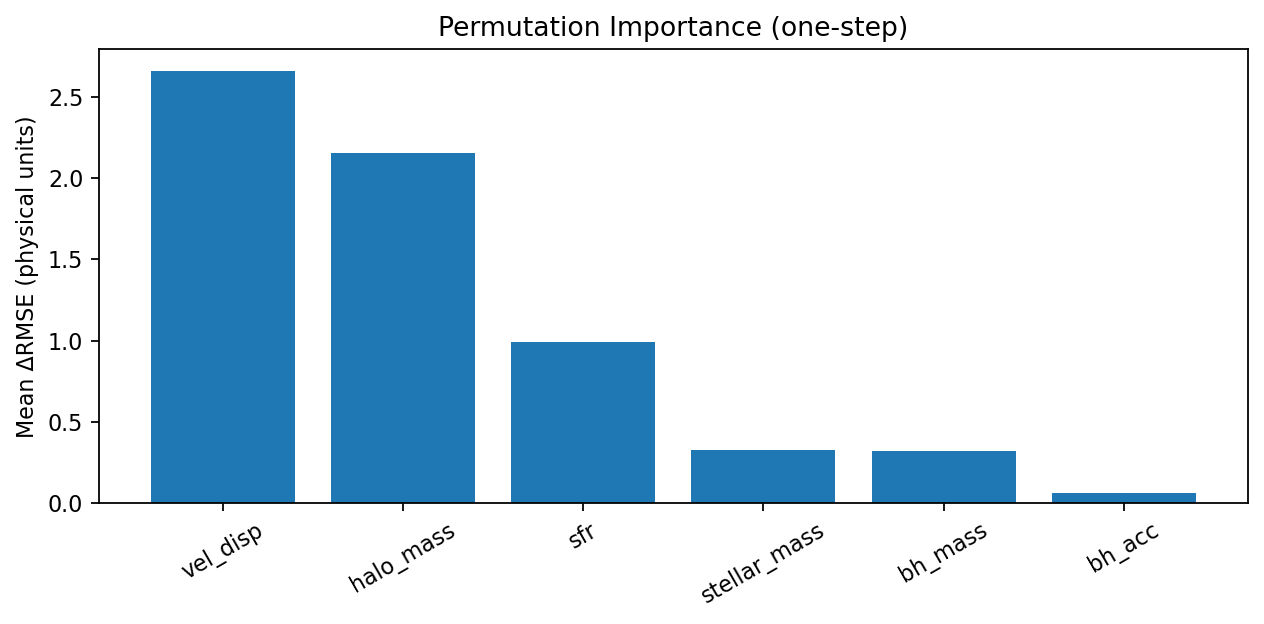

In [8]:
# 5 — Permutation importance (one-step; ΔRMSE in physical units) — self-contained

import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt
rng = np.random.default_rng(42)

# --- Rebuild 1-step windows (normalized) for evaluation
XW_1, Y1 = [], []
for sid in np.unique(ids):
    m = (ids == sid)
    s = snaps[m]
    x = Xraw[m]
    order = np.argsort(s)
    x = x[order]
    x = (x - mean) / (std + 1e-8)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    if len(x) <= WINDOW:
        continue
    for t in range(WINDOW, len(x)):
        XW_1.append(x[t-WINDOW:t, :])  # [W, F]
        Y1.append(x[t, :])             # [F]

if not XW_1:
    raise RuntimeError("No 1-step windows available. Reduce WINDOW or check data length.")

XW_1 = np.stack(XW_1).astype(np.float32)   # [N,W,F]
Y1    = np.stack(Y1).astype(np.float32)    # [N,F]

@torch.no_grad()
def pred_norm(Xw):
    xb = torch.from_numpy(Xw).float().to(device)
    return model(xb).cpu().numpy()

# Baseline physical RMSE
P0   = pred_norm(XW_1)
P0_r = P0 * std + mean
Y1_r = Y1 * std + mean
base = np.sqrt(np.mean((P0_r - Y1_r)**2, axis=0))  # [F]

rows = []
for j_in, name in enumerate(FEATURES):
    Xp = XW_1.copy()
    # permute this input feature across samples at each time index
    for t in range(WINDOW):
        perm = rng.permutation(Xp.shape[0])
        Xp[:, t, j_in] = Xp[perm, t, j_in]
    Pp   = pred_norm(Xp)
    Pp_r = Pp * std + mean
    delta = np.sqrt(np.mean((Pp_r - Y1_r)**2, axis=0)) - base
    rows.append({"input_feature": name, **{f"ΔRMSE→{FEATURES[j]}": float(delta[j]) for j in range(F)}})
    print(f"[5] permuted {name} | ΔRMSE(mean)={float(delta.mean()):.3e}")

imp_df = pd.DataFrame(rows)
imp_df["ΔRMSE_mean"] = imp_df[[c for c in imp_df.columns if c.startswith("ΔRMSE→")]].mean(axis=1)
imp_df.sort_values("ΔRMSE_mean", ascending=False, inplace=True)

imp_csv = TAB_DIR / "permutation_importance_ranked.csv"
imp_df.to_csv(imp_csv, index=False)

plt.figure(figsize=(8,4))
plt.bar(imp_df["input_feature"], imp_df["ΔRMSE_mean"])
plt.xticks(rotation=30); plt.ylabel("Mean ΔRMSE (physical units)")
plt.title("Permutation Importance (one-step)")
fig_pi = FIG_DIR / "permutation_importance.png"
plt.tight_layout(); plt.savefig(fig_pi, dpi=200)

print(f"[5] Saved: {imp_csv}, {fig_pi}")


[6] PDP varied bh_mass
[6] PDP varied bh_acc
[6] PDP varied stellar_mass
[6] PDP varied sfr
[6] PDP varied halo_mass
[6] PDP varied vel_disp
[6] Saved ../data/results/figures/pdp_bh_mass.png
[6] Saved ../data/results/figures/pdp_bh_acc.png
[6] PDP table: ../data/results/tables/pdp_laststep_mean.csv


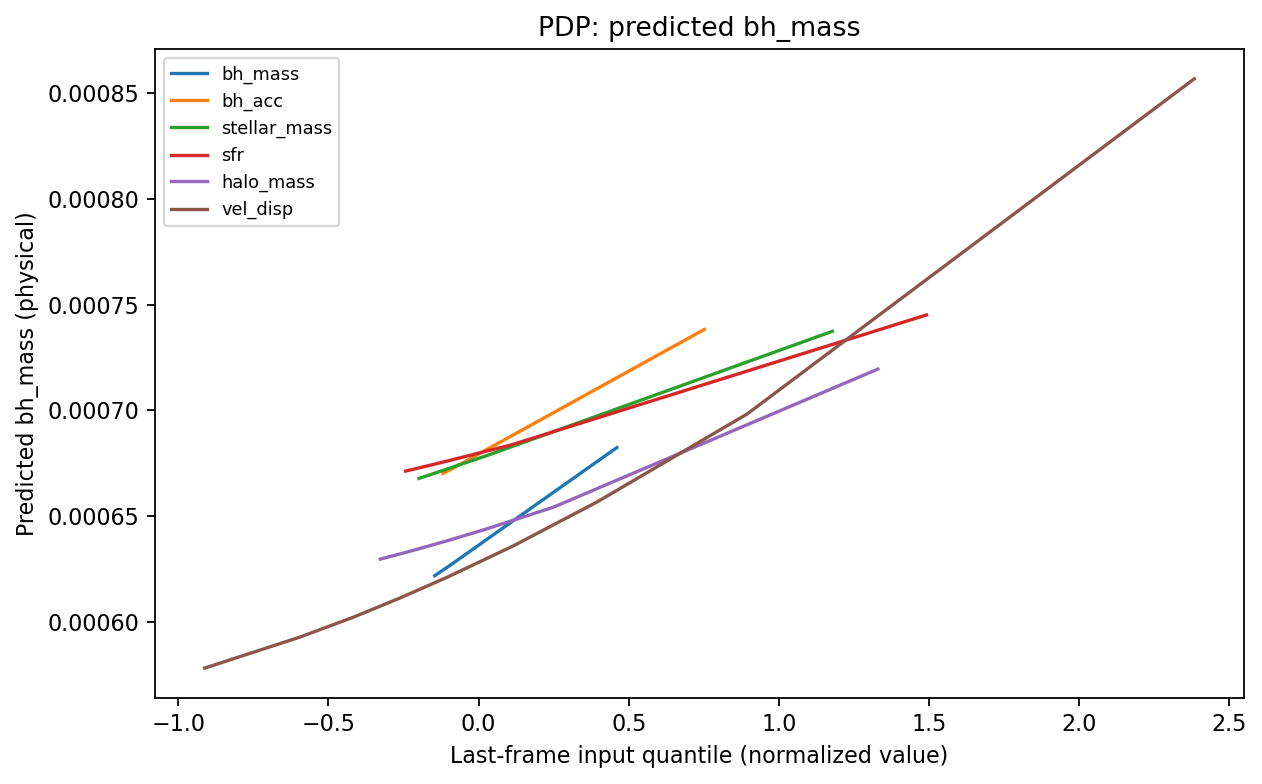

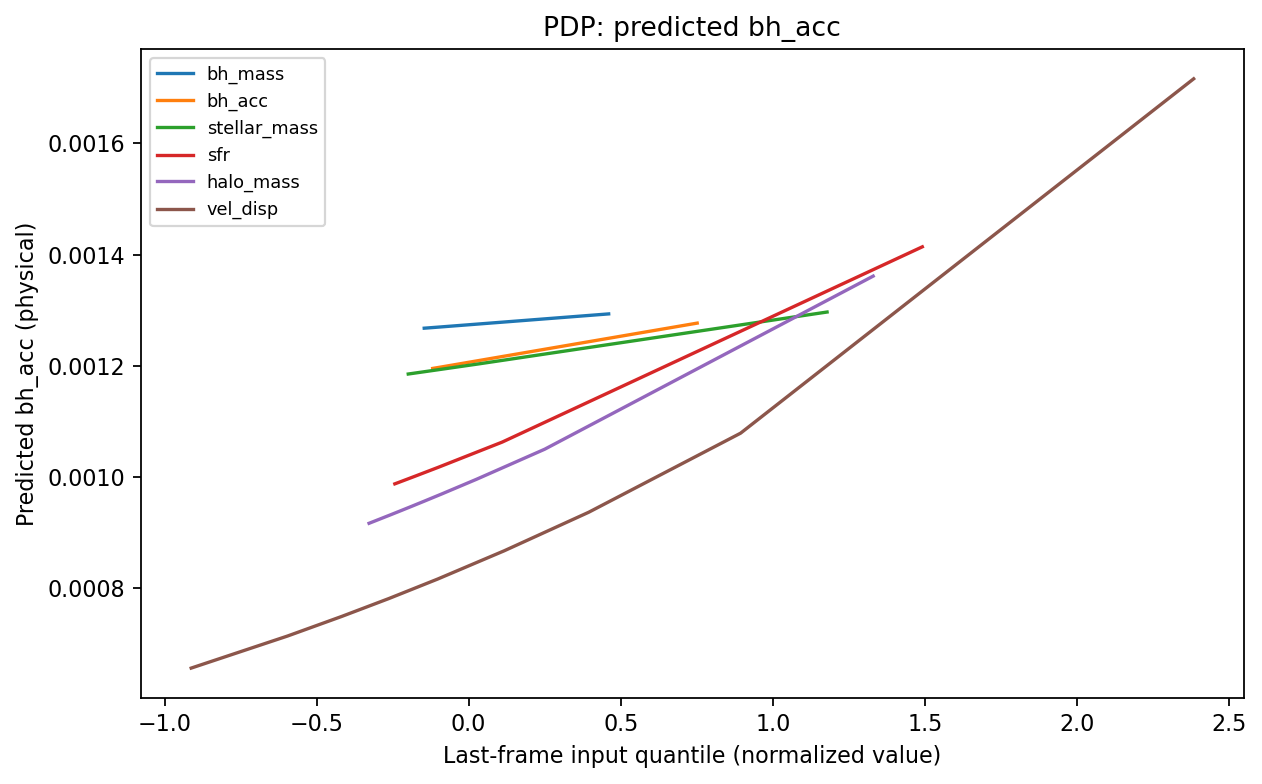

In [9]:
# 6 — Partial Dependence (vary last-frame input quantile; predicted outputs) — self-contained

import numpy as np, pandas as pd, torch, matplotlib.pyplot as plt

# --- Rebuild a compact 1-step window set for PDP (normalized)
XW_pdp = []
for sid in np.unique(ids):
    m = (ids == sid)
    s = snaps[m]
    x = Xraw[m]
    order = np.argsort(s)
    x = x[order]
    x = (x - mean) / (std + 1e-8)
    x = np.nan_to_num(x, nan=0.0, posinf=0.0, neginf=0.0)
    if len(x) <= WINDOW:
        continue
    for t in range(WINDOW, len(x)):
        XW_pdp.append(x[t-WINDOW:t, :])
if not XW_pdp:
    raise RuntimeError("No PDP windows available. Reduce WINDOW or check data length.")
XW_pdp = np.stack(XW_pdp).astype(np.float32)

# Subsample for speed
N_sub = min(1000, len(XW_pdp))
idx = np.random.default_rng(123).choice(len(XW_pdp), size=N_sub, replace=False)
Xsub = XW_pdp[idx].copy()

quantiles = np.linspace(0.05, 0.95, 9)
rows = []

@torch.no_grad()
def predict_phys(Xw):
    z = model(torch.from_numpy(Xw).float().to(device)).cpu().numpy()
    return z * std + mean  # physical

for j_in, name in enumerate(FEATURES):
    base_vals = Xsub[:, -1, j_in]
    qs = np.quantile(base_vals, quantiles)
    for qv in qs:
        Xm = Xsub.copy()
        Xm[:, -1, j_in] = qv
        preds_r = predict_phys(Xm)      # [N_sub, F]
        mu = preds_r.mean(axis=0)       # [F]
        rows.append({
            "input_feature": name,
            "last_step_quantile": float(qv),
            **{f"pred_{FEATURES[j]}": float(mu[j]) for j in range(F)}
        })
    print(f"[6] PDP varied {name}")

pdp_df = pd.DataFrame(rows)
pdp_csv = TAB_DIR / "pdp_laststep_mean.csv"
pdp_df.to_csv(pdp_csv, index=False)

# Plot PDP for two key targets
for tgt in ["bh_mass","bh_acc"]:
    plt.figure(figsize=(8,5))
    for name in FEATURES:
        sub = pdp_df[pdp_df["input_feature"] == name].sort_values("last_step_quantile")
        plt.plot(sub["last_step_quantile"], sub[f"pred_{tgt}"], label=name)
    plt.xlabel("Last-frame input quantile (normalized value)")
    plt.ylabel(f"Predicted {tgt} (physical)")
    plt.title(f"PDP: predicted {tgt}")
    plt.legend(fontsize=8)
    fp = FIG_DIR / f"pdp_{tgt}.png"
    plt.tight_layout(); plt.savefig(fp, dpi=200)
    print(f"[6] Saved {fp}")

print(f"[6] PDP table: {pdp_csv}")
